# Budget-based SVR

The basic SVR algorithm solves the following optimization problem:

$$\min \frac{1}{2} ||w||^2 + C \sum(\xi_i + \hat\xi_i)$$

under the constraints

$$y_i - \epsilon - \xi_i \leq w \cdot x_i + b
          \leq y_i + \epsilon + \hat\xi_i \\
  \xi_i, \hat\xi_i \geq 0$$

The Wolfe dual is

$$\min_{\alpha, \hat\alpha} \frac{1}{2} \sum_{i, j}
  (\alpha_i - \hat\alpha_i) (\alpha_j - \hat\alpha_j) k(x_i, x_j)
  - \sum_i (\alpha_i - \hat\alpha_i) y_i
  + \sum_i (\alpha_i + \hat\alpha_i) \epsilon$$

under the constraints

$$\sum_i (\alpha_i - \hat\alpha_i) = 0 \\
  0 \leq \alpha_i, \hat\alpha_i \leq C$$

The budget-based version, instead, focuses on

$$\min_{\alpha, \hat\alpha, \gamma} \frac{1}{2} \sum_{i, j}
  (\alpha_i - \hat\alpha_i) (\alpha_j - \hat\alpha_j) k(x_i, x_j)
  - \sum_i (\alpha_i - \hat\alpha_i) y_i
  + \sum_i (\alpha_i + \hat\alpha_i) \epsilon
  + \gamma B$$

under the constraints

$$\sum_i (\alpha_i - \hat\alpha_i) = 0 \\
  \alpha_i - \gamma \leq C  \\
  \hat\alpha_i - \gamma \leq C \\
  \alpha_i, \hat\alpha_i, \gamma \geq 0$$

The KKT conditions are

$$\alpha_i(w \cdot x_i + b - y_i + \epsilon + \xi_i) = 0 \\
  \hat\alpha_i(y_i + \epsilon + \hat\xi_i - w \cdot x_i - b) = 0 \\
  \beta_i \xi_i = 0, \hat\beta_i \hat\xi_i = 0 \\
  \gamma B \sum(\xi_i + \hat\xi_i) = 0$$

So that if the optimal value of $\gamma$ is zero, $b$ is
found as usual, otherwise $b = y_i - \epsilon - w \cdot x_i$ with $i$ such
that $\alpha_i < C + \gamma$, still considering optimal values of
variables. Note that in both cases $b$ can be found considering $i$ such
that $\alpha_i < C + \gamma$. Similar considerations hold for the hatted
set of variables.

In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from optimization import GurobiSolver
from kernel import LinearKernel, GaussianKernel

def generate_data():
    n = 50
    a = 1.5
    b = 0.3

    X = np.random.random(n)
    y = a * X + b + np.random.random(n) / 2

    return X, y

def feature_dot(x_new, sv, kernel):
    return sum([a * kernel.compute(x, x_new) for (a, x) in sv])

X, y = generate_data()
s = GurobiSolver()


interactive(children=(FloatSlider(value=1.0, description='C', max=1000.0, min=0.001, step=0.001), FloatSlider(…

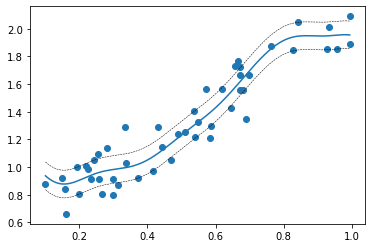

In [2]:

@widgets.interact(C=widgets.FloatSlider(min=1E-3, max=1E3, step=.001, value=1),
                  sigma=widgets.FloatSlider(min=1E-4, max=3, step=0.1, 
                                           value=0.1),
                  epsilon=widgets.FloatSlider(min=0.01, max=1,
                                              step=.01, value=.1),
                  B=widgets.FloatSlider(min=0.01, max=10, step=.5, value=1)
                  )
def f(C, sigma, epsilon, B):
    k = GaussianKernel(sigma)
    alpha, alpha_hat = s.solve(X, y, C=1, kernel=k, epsilon=epsilon)

    sv = [(a - a_h, x) for a, a_h, x in zip(alpha, alpha_hat, X)
                                     if a - a_h != 0]
    
    global aaa
    aaa = sv

    b_values = [y_ - feature_dot(x, sv, k) - epsilon
                for a, x, y_ in zip(alpha, X, y) if 0 < a < C]
    b_values += [y_ - feature_dot(x, sv, k) + epsilon
                for a_h, x, y_ in zip(alpha_hat, X, y) if 0 < a_h < C]

    b = np.mean(b_values)

    regression = lambda x: feature_dot(x, sv, k) + b

    x_values = np.linspace(min(X), max(X), 500)

    fig, ax = plt.subplots()
    ax.scatter(X, y)
    ax.plot(x_values, [regression(x) for x in x_values])
    ax.plot(x_values, [regression(x) + epsilon for x in x_values],
            'k--', linewidth=.5)
    ax.plot(x_values, [regression(x) - epsilon for x in x_values],
            'k--', linewidth=.5)

    alpha, alpha_hat, gamma = s.solve(X, y, C, k, epsilon, budget=B)

    budget_sv = [(a - a_h, x) for a, a_h, x
             in zip(alpha, alpha_hat, X) if a - a_h != 0]


    budget_b_values = [y_ - feature_dot(x, sv, k) - epsilon
                for a, x, y_ in zip(alpha, X, y) if 0 < a < C + gamma]
    budget_b_values += [y_ - feature_dot(x, sv, k) + epsilon
                for a_h, x, y_ in zip(alpha_hat, X, y) if 0 < a_h < C + gamma]

    budget_b = np.mean(b_values)

    budget_regression = lambda x: feature_dot(x, budget_sv, k) + budget_b

    ax.plot(x_values, [budget_regression(x) + epsilon for x in x_values],
            'r:', linewidth=.5)
    ax.plot(x_values, [budget_regression(x) for x in x_values], 'r')
    ax.plot(x_values, [budget_regression(x) - epsilon for x in x_values],
            'r:', linewidth=.5)
    #return alpha, alpha_hat

## Budget-based SV classification

The original dual problem in SV classification is

\begin{equation*}
\max \sum_i \alpha_i - \frac{1}{2} \sum_{i,j} \alpha_i \alpha_j y_i y_j k(x_i, x_j)
\end{equation*}

under the constraints

\begin{eqnarray*}
\sum_i \alpha_i y_i = 0 \\
0 \leq \alpha_i \leq C
\end{eqnarray*}

Once this problem has been solved, the classification involves evaluating an expression depending on the non-null optimal values for the lagrangian variables $\alpha_i$, in turn related to the related values $x_i$, termed support vectors. When this number grows, this can affect the space needed in order to store the induced classifier, as well as the time and energy consumption needed in order to query it.

We propose therefore to fix a budget $B > 0$ related to the number of support vectors to be used. Consider the following modified form of the above mentioned dual problem.

\begin{equation*}
\max \sum_i \alpha_i - \frac{1}{2} \sum_{i,j} \alpha_i \alpha_j y_i y_j k(x_i, x_j) + P(\gamma_1, \dots, \gamma_n)
\end{equation*}

under the constraints

\begin{eqnarray*}
\sum_i \alpha_i y_i = 0 \\
0 \leq \alpha_i \leq C \gamma_i \\
0 \leq \gamma_i \leq 1 \\
\sum_i \gamma_i \leq B
\end{eqnarray*}

where $P(\gamma_1, \dots, \gamma_n)$ is a term promoting the optimization process towards values for the additional variables $\gamma_i$ either equal to $0$ or to $1$, for instance $P(\gamma_1, \dots, \gamma_n) = \prod_i -\gamma_i (1 - \gamma_i)$ or $P(\gamma_1, \dots, \gamma_n) = \prod_i \left( \gamma_i^{\gamma_i} (1 - \gamma_i)^{1 - \gamma_i} - 1 \right)$.

In [1]:
def p_1(x):
    return -x * (1 - x)

def p_2(x):
    return x**x * (1-x)**(1-x) - 1

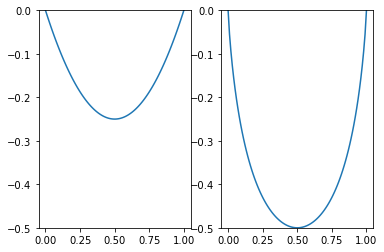

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 1, 100)
plt.subplot(121)
y = p_1(x)
plt.plot(x, y)
plt.ylim(-0.5, 0)

plt.subplot(122)
y = p_2(x)
plt.plot(x, y)
plt.ylim(-0.5, 0)

plt.show()

The optimal value of the new variables $\gamma_i$ is likely to be either $0$ or $1$: in the first case, the constraint $0 \leq \alpha_i \leq C \gamma_i$ reads $\alpha_i = 0$, and thus the related $x_i$ will not be a support vector, while in the second one $\alpha_i$ is free to assume values in the usual interval $[0, C]$, which means it might or not be a support vector. This means that $\sum_i \gamma_i$ is approximately equal to the number of times $\gamma_i \neq 0$, and thus it is an upper bound to the number of support vectors. Summing up, the added constraint $\sum_i \gamma_i \leq B$ implies that the total number of support vectors will not exceed $B$.

We plan to experimentally analyse this budgeted version of SVM classification in the following three scenarios.

1. When the classification complexity of a dataset grows, it is expected that a higher number of support vectors is needed in order to build the corresponding SV classifier, with the above-mentioned issues related to space, time, and energy consumption. In such a case, we plan to study how the less demanding classifier obtained using the budgeted version introduces a degradation in classification performance. Precisely, by considering various datasets of increasing classification complexity, and, for each dataset, different values of the budget B, we will experimentally compute the degradation of the budgeted classifier w.r.t. the classical one.

2. When the dataset to be used for solving a classification problem has a huge size, solving the optimization problem at the basis of SV classification might be impossible, because the used solver is not able to handle as much as independent variables as needed. In such cases, the dataset can be divided into chunks of size sufficiently low to be processed by the used solver, in conjunction with a budget allowing to get a classifier using at most a predefined fraction of the training set as a support vector. These support vectors can be merged with the following chunks, repeating the process until the whole dataset has been processed. This approach, although suboptimal, can be therefore used to scale up SV classification to a big-data setting.

3. TO BE CHECKED: if the number of outliers can be shown to affect the number of support vectors, the budgeted version can be used in order to address the outliers problem.

## Scenario 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from optimization import GurobiSolver
from kernel import LinearKernel, PolynomialKernel, GaussianKernel

def generate_data(n=10, split=0.5):
    y = np.random.uniform(size=n)
    n_pos = int(n * split)
    y_pos = y[:n_pos]
    y_neg = y[n_pos:]
    return np.array([[0.2, y] for y in y_pos] + [[0.8, y] for y in y_neg]), [1] * n_pos + [-1] * (n - n_pos)
    

In [2]:
X, y = generate_data(n=100)

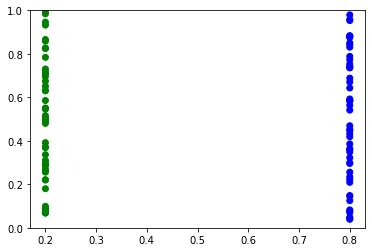

In [3]:
def gr_dataset(X, y, df=None):
    
    color = np.vectorize(lambda l: 'green' if l==1 else 'blue')

    plt.scatter(*X.T, c=color(y))
    x = np.linspace(0, 1, 200)
    if df is not None:
        plt.plot(x, df(x))
    plt.ylim(0, 1)
    plt.show()
    
    
gr_dataset(X, y)

In [4]:
s = GurobiSolver(problem='classification')
C = 10
k = LinearKernel()

In [5]:
sol_classic = s.solve(X, y, budget=None, C=C, kernel=k)

In [6]:
sum(sol_classic > 0)

100

In [7]:
def get_sv_classifier(X, y, sol, C, k):
    X = np.array(X)
    y = np.array(y)
    sv_mask = (0 < sol) & (sol < C)
    

    alpha = sol
    
    def dotprod(x_new):
        return np.sum([a * y_i * k.compute(x, x_new) for x, y_i, a in zip(X, y, alpha)])
    
    bs = [y_i - dotprod(x) for x, y_i, a in zip(X, y, alpha) if a > 0 and a < C]
    b = np.mean(bs)
    if np.std(bs) > 1E-6:
        print('warning: computed values for b are', bs)
    
    def classifier(x1, x2):
        return dotprod((x1, x2)) + b
    
    return classifier

In [8]:
sv_classifier = get_sv_classifier(X, y, sol_classic, C, k)

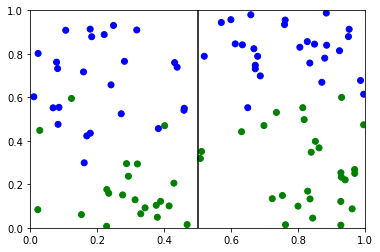

In [36]:
def gr_classifier(classifier, X, y, margin=False):
    x_range = np.linspace(0, 1, 30)
    y_range = np.linspace(0, 1, 30)
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    z = np.array([classifier(*a) for a in np.array((np.ravel(x_grid), np.ravel(y_grid))).T])
    z_grid = z.reshape(x_grid.shape)

    plt.contour(x_grid, y_grid, z_grid, [0], colors='k')
    if margin:
        plt.contour(x_grid, y_grid, z_grid, [-1, 1], colors='k', linestyles='dashed')

    gr_dataset(X, y)

    plt.show()

gr_classifier(sv_classifier, X, y)

In [10]:
sol_budget = s.solve(X, y, budget=3, C=C, kernel=k)
sum(sol_budget > 0)

3

In [11]:
sv_classifier_budget = get_sv_classifier(X, y, sol_budget, C, k)

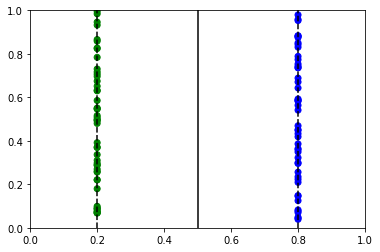

In [12]:
gr_classifier(sv_classifier_budget, X, y)

## Roba vecchia o da tenere da parte

In [13]:
def decision_function(beta=1, rho=0.5, theta=1):
    return lambda x: 1 / (1 + np.exp(-beta*(x-0.5) ) ) + rho * np.sin(2 * np.pi * theta * x)

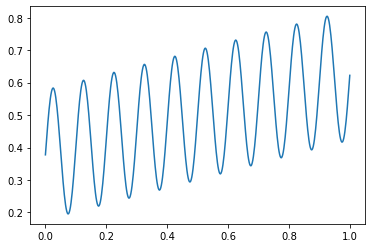

In [14]:
df = decision_function(beta=1, rho=0.2, theta=10)
x_df = np.linspace(0, 1, 500)
y_df = df(x_df)

plt.plot(x_df, y_df)
plt.show()

In [19]:
def generate_data(n=100, left=0, right=1):

    X = np.random.uniform(size=(n, 2), low=left, high=right)
    
    df = decision_function(beta=1, rho=0.2, theta=10)
    labeling_function = lambda x0, x1: np.sign(df(x0) - x1)
    y = labeling_function(*X.T)

    return X, y

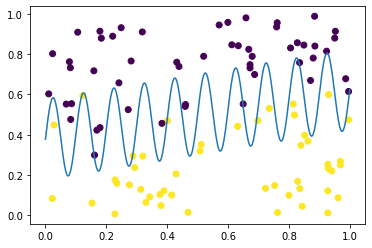

In [20]:
X, y = generate_data()

plt.plot(x_df, y_df)

plt.scatter(*X.T, c=y)
plt.show()

In [23]:
gamma_values

['auto',
 'scale',
 1e-08,
 1.668100537200059e-07,
 2.782559402207126e-06,
 4.641588833612782e-05,
 0.0007742636826811277,
 0.012915496650148853,
 0.21544346900318867,
 3.5938136638046405,
 59.94842503189421,
 1000.0]

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

c_values = np.logspace(-4, 3, 10)
gamma_values = ['auto', 'scale'] + list(np.logspace(-8, 4, 10))
grid = {'C': c_values, 'gamma': gamma_values}

gs = GridSearchCV(SVC(), grid, refit=True)
gs.fit(X, y)
model = gs.best_estimator_


# svc = SVC(C=1000, gamma=100)
# svc.fit(X, y)
# model = svc

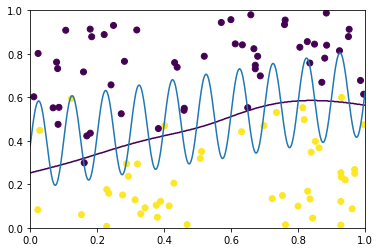

In [25]:
xx, yy = np.meshgrid(np.linspace(0, 1, 500), np.linspace(0, 1, 500))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.scatter(*X.T, c=y)

plt.contour(xx, yy, Z, [0])

plt.plot(x_df, y_df)

plt.show()

In [26]:
gs.best_params_

{'C': 0.1291549665014884, 'gamma': 21.54434690031878}

In [45]:
best_sv_accuracy = gs.best_score_

In [39]:
from kernel import GaussianKernel

C = 1000
k = LinearKernel()
#k = GaussianKernel(0.1)

sol_budget = s.solve(X, y, budget=100, C=C, kernel=k)
sum(sol_budget > 0)

18

In [40]:
sv_classifier_budget = get_sv_classifier(X, y, sol_budget, C, k)

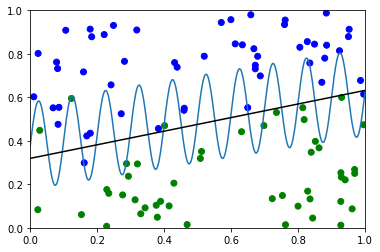

In [41]:
plt.plot(x_df, y_df)

gr_classifier(sv_classifier_budget, X, y)

In [75]:
from sklearn import metrics

In [76]:
def get_accuracy(b):
    sol_budget = s.solve(X, y, budget=b, C=C, kernel=k)
    sv_classifier_budget = get_sv_classifier(X, y, sol_budget, C, k)
    return sum(sol_budget > 0)/b, metrics.accuracy_score([np.sign(sv_classifier_budget(*x)) for x in X], y)

In [77]:
budget_values = np.arange(13, 25)
max_budget = X.shape[0]

In [78]:
result = np.array([get_accuracy(b) for b in budget_values])

In [80]:
budget_used, budget_accuracies = result.T

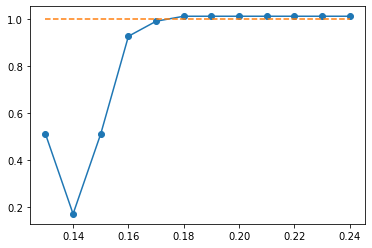

In [84]:
plt.plot(budget_values / max_budget, budget_accuracies / best_sv_accuracy, '-o')
plt.plot(budget_values / max_budget, [1] *  len(budget_values), '--')
plt.show()

In [82]:
budget_used

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.94736842, 0.9       , 0.85714286, 0.81818182,
       0.7826087 , 0.75      ])